In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
import pandas as pd
import numpy as np
import os

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

from nltk.corpus import stopwords
from nltk.util import ngrams

from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics import classification_report,confusion_matrix

from collections import defaultdict
from collections import Counter
plt.style.use('ggplot')
stop=set(stopwords.words('english'))

import re
from nltk.tokenize import word_tokenize
import gensim
import string

from tqdm import tqdm
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM,Dense, SpatialDropout1D, Dropout
from keras.initializers import Constant
from keras.optimizers import Adam

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [0]:
with open('/content/gdrive/My Drive/test.csv', 'r') as f:
   test = pd.read_csv(f)

In [0]:
with open('/content/gdrive/My Drive/train.csv', 'r') as f:
   train = pd.read_csv(f)

In [6]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [14]:
train.text[500]

'Christian Attacked by Muslims at the Temple Mount after Waving Israeli Flag via Pamela Geller - ... http://t.co/LHBZHWq4B9'

In [0]:
ids_with_target_error = [328,443,513,2619,3640,3900,4342,5781,6552,6554,6570,6701,6702,6729,6861,7226]
train.loc[train['id'].isin(ids_with_target_error),'target'] = 0

In [0]:
Real_len = train[train['target'] == 1].shape[0]
Not_len = train[train['target'] == 0].shape[0]

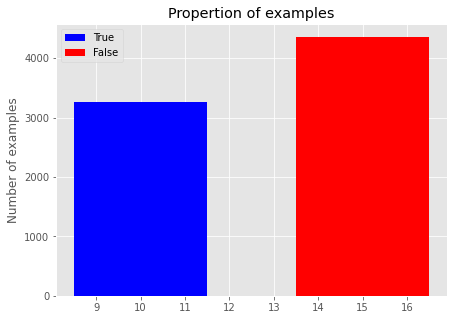

In [16]:
plt.rcParams['figure.figsize'] = (7, 5)
plt.bar(10,Real_len,3, label="True", color='blue')
plt.bar(15,Not_len,3, label="False", color='red')
plt.legend()
plt.ylabel('Number of examples')
plt.title('Propertion of examples')
plt.show()

In [41]:
print('Положительных объектов - ',len(train.loc[train.target == 1]))
print('Отрицательных объектов - ', len(train.loc[train.target == 0]))

Положительных объектов -  3255
Отрицательных объектов -  4358


In [0]:
def length(text):    
    return len(text)

In [0]:
train['length'] = train['text'].apply(length)

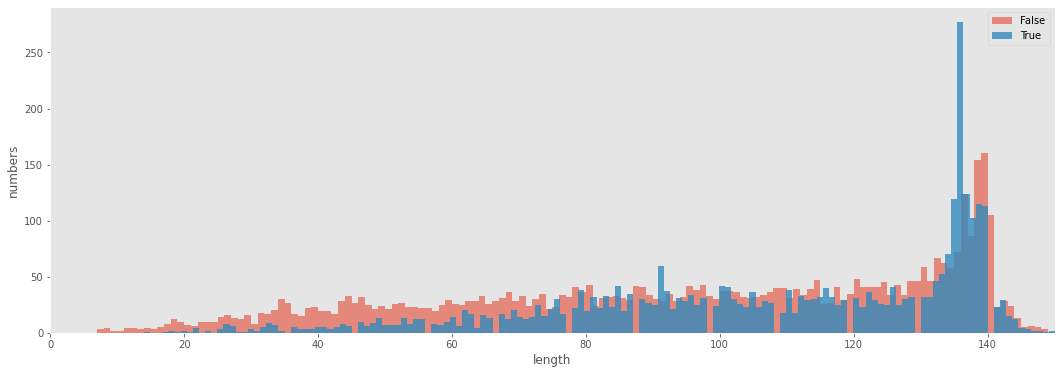

In [19]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
bins = 150
plt.hist(train[train['target'] == 0]['length'], alpha = 0.6, bins=bins, label='False')
plt.hist(train[train['target'] == 1]['length'], alpha = 0.8, bins=bins, label='True')
plt.xlabel('length')
plt.ylabel('numbers')
plt.legend(loc='upper right')
plt.xlim(0,150)
plt.grid()
plt.show()

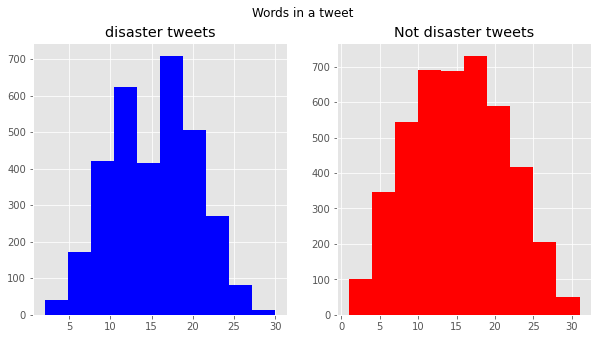

In [20]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
tweet_len=train[train['target']==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(tweet_len,color='blue')
ax1.set_title('disaster tweets')
tweet_len=train[train['target']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(tweet_len,color='red')
ax2.set_title('Not disaster tweets')
fig.suptitle('Words in a tweet')
plt.show()

Text(0.5, 0.98, 'Average word length in each tweet')

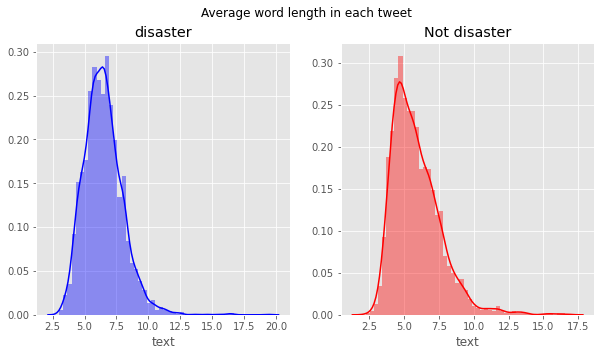

In [21]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
word=train[train['target']==1]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='blue')
ax1.set_title('disaster')
word=train[train['target']==0]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='red')
ax2.set_title('Not disaster')
fig.suptitle('Average word length in each tweet')

In [0]:
def get_top_tweet_bigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

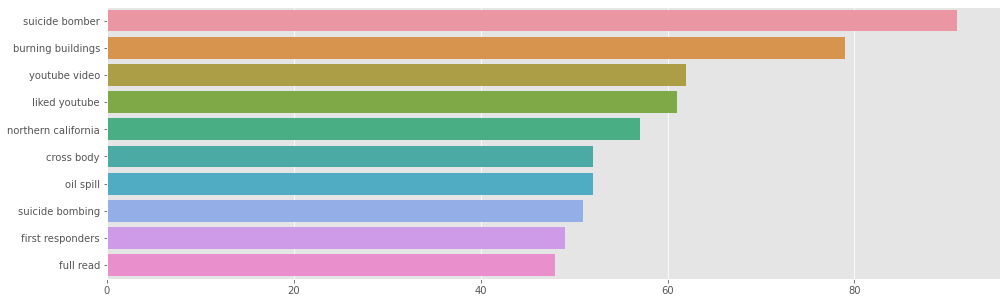

In [35]:
plt.figure(figsize=(16,5))
top_tweet_bigrams=get_top_tweet_bigrams(df['text'])[:10]
x,y=map(list,zip(*top_tweet_bigrams))
sns.barplot(x=y,y=x)

In [0]:
def get_top_tweet_bigrams_3(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

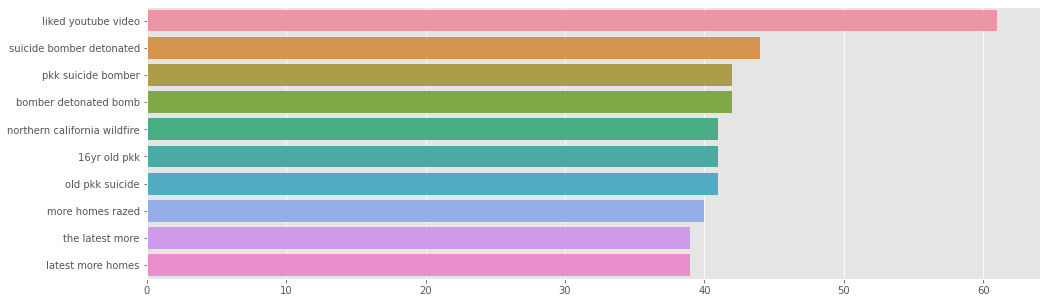

In [37]:
plt.figure(figsize=(16,5))
top_tweet_bigrams=get_top_tweet_bigrams_3(df['text'])[:10]
x,y=map(list,zip(*top_tweet_bigrams))
sns.barplot(x=y,y=x)

Cleaning

In [26]:
df=pd.concat([train,test])
df.shape

(10876, 6)

In [0]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

df['text']=df['text'].apply(lambda x : remove_URL(x))
df['text']=df['text'].apply(lambda x : remove_html(x))

In [0]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

df['text']=df['text'].apply(lambda x: remove_emoji(x))

In [0]:
def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

df['text']=df['text'].apply(lambda x : remove_punct(x))

In [0]:
def cv(data):
    count_vectorizer = CountVectorizer()

    emb = count_vectorizer.fit_transform(data)

    return emb, count_vectorizer

list_corpus = df["text"].tolist()
list_labels = df["target"].tolist()

X_train, X_test, y_train, y_test = train_test_split(list_corpus, list_labels, test_size=0.2, 
                                                                                random_state=17)

X_train_counts, count_vectorizer = cv(X_train)
X_test_counts = count_vectorizer.transform(X_test)

In [0]:
TEXT_LENGTH = 1800
VOCABULARY_SIZE = 250000
EMBEDDING_DIM = 300
DIMS = 250
MAX_FEATURES = 5000
batch_size = 32

nb_filter = 250
filter_length = 3
hidden_dims = 250
nb_epoch = 10

In [26]:
tokenizer = Tokenizer(num_words=MAX_FEATURES)
tokenizer.fit_on_texts(train.text)
tokenizer

In [0]:
sequences = tokenizer.texts_to_sequences(train.text)
X_train = tokenizer.sequences_to_matrix(sequences, mode='count')
sequences = tokenizer.texts_to_sequences(test.text)
X_test = tokenizer.sequences_to_matrix(sequences, mode='count')

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_train, train.target, test_size = 0.2, random_state = 42)

In [29]:
X_train[0]

array([0., 1., 1., ..., 0., 0., 0.])

In [30]:
model = Sequential()
model.add(Dense(128, input_shape=(MAX_FEATURES,), activation = 'relu'))
model.add(Dropout(0.1))
model.add(Dense(128, activation = 'relu'))
model.add(Dense(64, activation = 'relu'))
model.add(Dense(64, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=30, batch_size=128,  validation_split=0.1)

Train on 5481 samples, validate on 609 samples
Epoch 1/30
5481/5481 [==============================] - 2s 387us/step - loss: 0.5844 - accuracy: 0.6948 - val_loss: 0.4238 - val_accuracy: 0.8210
Epoch 2/30
5481/5481 [==============================] - 0s 47us/step - loss: 0.3192 - accuracy: 0.8717 - val_loss: 0.4221 - val_accuracy: 0.8194
Epoch 3/30
5481/5481 [==============================] - 0s 44us/step - loss: 0.1805 - accuracy: 0.9358 - val_loss: 0.5425 - val_accuracy: 0.8342
Epoch 4/30
5481/5481 [==============================] - 0s 46us/step - loss: 0.1060 - accuracy: 0.9657 - val_loss: 0.5879 - val_accuracy: 0.8161
Epoch 5/30
5481/5481 [==============================] - 0s 49us/step - loss: 0.0734 - accuracy: 0.9734 - val_loss: 0.6993 - val_accuracy: 0.8128
Epoch 6/30
5481/5481 [==============================] - 0s 45us/step - loss: 0.0596 - accuracy: 0.9799 - val_loss: 0.7447 - val_accuracy: 0.8062
Epoch 7/30
5481/5481 [==============================] - 0s 47us/step - loss: 0.053

BERT

In [0]:
!wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py

In [32]:
!pip3 install sentencepiece
!pip3 install tf_sentencepiece

     |████████████████████████████████| 1.0MB 4.9MB/s 
     |████████████████████████████████| 2.1MB 4.8MB/s 


In [0]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow_hub as hub

import tokenization

In [0]:
def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence)
        tokens += [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

In [0]:
random_state_split = 10
Dropout_num = 0
learning_rate = 6e-6
valid = 0.2
epochs_num = 3
batch_size_num = 16
target_corrected = False
target_big_corrected = False

In [0]:
def build_model(bert_layer, max_len=512):
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    _, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    clf_output = sequence_output[:, 0, :]
    
    if Dropout_num == 0:
        # Without Dropout
        out = Dense(1, activation='sigmoid')(clf_output)
    else:
        # With Dropout(Dropout_num), Dropout_num > 0
        x = Dropout(Dropout_num)(clf_output)
        out = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(Adam(lr=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [0]:
stops = set(stopwords.words('english'))

In [0]:
def no_stops(text):
    STOPWORDS = set(stopwords.words('english'))
    return ' '.join([word for word in text.split() if word not in STOPWORDS])

df['text']=df['text'].apply(lambda x : no_stops(x))

'Our Deeds Reason earthquake May ALLAH Forgive us'

In [0]:
train["text"] = train["text"].apply(lambda x: remove_emoji(x))
train["text"] = train["text"].apply(lambda x: remove_html(x))
train["text"] = train["text"].apply(lambda x: remove_punct(x))
train["text"] = train["text"].apply(lambda x: remove_URL(x))

In [0]:
module_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/1"
bert_layer = hub.KerasLayer(module_url, trainable=True)

In [0]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [0]:
train_input = bert_encode(train.text.values, tokenizer, max_len=160)
test_input = bert_encode(test.text.values, tokenizer, max_len=160)
train_labels = train.target.values

In [56]:
model_BERT = build_model(bert_layer, max_len=160)
model_BERT.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 160)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 160)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 160)]        0                                            
__________________________________________________________________________________________________
keras_layer_1 (KerasLayer)      [(None, 1024), (None 335141889   input_word_ids[0][0]             
                                                                 input_mask[0][0]           

In [57]:
checkpoint = ModelCheckpoint('model_BERT.h5', monitor='val_loss', save_best_only=True)

train_history = model_BERT.fit(
    train_input, train_labels,
    validation_split = 0.2,
    epochs = 3, 
    callbacks=[checkpoint],
    batch_size = 32
)

Epoch 1/3
381/381 [==============================] - 453s 1s/step - loss: 0.4401 - accuracy: 0.8072 - val_loss: 0.3888 - val_accuracy: 0.8293
Epoch 2/3
381/381 [==============================] - 378s 992ms/step - loss: 0.2890 - accuracy: 0.8839 - val_loss: 0.4652 - val_accuracy: 0.8253
Epoch 3/3
381/381 [==============================] - 378s 993ms/step - loss: 0.1673 - accuracy: 0.9365 - val_loss: 0.4623 - val_accuracy: 0.8234
